# Bandgap Prediction

Using QM9 data set to predict the bandgap of molecules using LSTM and GNN's

In [2]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader as GraphDataLoader
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from rdkit import RDLogger
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

In [3]:
def load_qm9(path="./QM9"):
    return QM9(path)

qm9 = load_qm9()
smiles = []
coords = []
homo_lumo_gaps = []
stock_gap = []
homo = []
lumo = []

for entry in qm9:
    smiles.append(entry.smiles)  # Get SMILES notation
    coords.append(entry.pos)     # Get atomic coordinates
    homo_energy = entry.y[0, 2].item()  # Get HOMO energy from the tensor
    homo.append(homo_energy)
    lumo_energy = entry.y[0, 3].item()  # Get LUMO energy from the tensor
    lumo.append(lumo_energy)
    gap_stock = entry.y[0, 4].item() 
    gap = lumo_energy - homo_energy  # Calculate the bandgap
    stock_gap.append(gap_stock)
    homo_lumo_gaps.append(gap)  # Store the bandgap
# Creating a DataFrame
qm9_data = pd.DataFrame({
    "SMILES": smiles,
    "Coordinates": coords,
    "HOMO" : homo,
    "LUMO" : lumo,
    "Egap" : stock_gap
})

print(qm9_data.head())

              SMILES                                        Coordinates  \
0  [H]C([H])([H])[H]  [[tensor(-0.0127), tensor(1.0858), tensor(0.00...   
1       [H]N([H])[H]  [[tensor(-0.0404), tensor(1.0241), tensor(0.06...   
2            [H]O[H]  [[tensor(-0.0344), tensor(0.9775), tensor(0.00...   
3          [H]C#C[H]  [[tensor(0.5995), tensor(0.), tensor(1.)], [te...   
4             [H]C#N  [[tensor(-0.0133), tensor(1.1325), tensor(0.00...   

        HOMO      LUMO       Egap  
0 -10.549854  3.186453  13.736308  
1  -6.993326  2.255824   9.249149  
2  -7.967494  1.869422   9.836916  
3  -7.741639  1.376896   9.118535  
4  -9.806983  0.519737  10.329442  


In [4]:
def pad_start_end_token(smiles):
    """
    Pad a list of SMILES with "SOS" and "EOS" token
    
    Parameters
    ----------
    smiles: list of str
        A list containing SMILES strings to pad
    
    Returns
    ------
    padded: list of list of str
        A list containing padded SMILES strings. Example: [['SOS', 'C', 'EOS'], ...]
    """
    padded = []
    for smile in smiles:
        padded.append(['SOS'] + list(smile) + ['EOS'])
    
    return padded

In [5]:
padded_smiles = pad_start_end_token(qm9_data["SMILES"])
vocab = np.unique(np.concatenate(padded_smiles))

In [6]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, vocab, y):
        
        self.vocab = np.array(vocab, dtype=str).reshape(-1, 1)
        
        self.encoder = OneHotEncoder()
        # fit the encoder
        self.encoder.fit(self.vocab)

        self.y = y
        
        # one-hot encoding
        self.data = [
            torch.tensor(
                self.encoder.transform(np.array(s).reshape(-1, 1)).toarray(),
                dtype=torch.float
            ) for s in smiles
        ]
        
        self.data = nn.utils.rnn.pad_sequence(self.data, batch_first=True)
        self.X = self.data[:, :-1, :]
        
    def __len__(self):
        return int(self.data.shape[0])
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
data_homo = SmilesDataset(padded_smiles, vocab, qm9_data["HOMO"])
data_homo_lite = SmilesDataset(padded_smiles[:50000], vocab, qm9_data["HOMO"][:50000])

data_lumo = SmilesDataset(padded_smiles, vocab, qm9_data["LUMO"])
data_lumo_lite = SmilesDataset(padded_smiles[:50000], vocab, qm9_data["LUMO"][:50000])
input_size = data_homo.vocab.shape[0]

In [8]:
RDLogger.DisableLog("rdApp.*")

class Trainer:
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")

        self.epoch = epoch
        self.batch_size = batch_size

    def train(self, train_data, draw_curve=True):
        self.encoder = train_data.encoder

        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        train_loss_list, train_acc_list = [], []

        loss_func = nn.L1Loss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss, epoch_err = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = y_batch.shape[0] / len(train_data)
                y_pred, _ = self.model(X_batch)
                batch_loss = loss_func(y_pred.flatten(), y_batch.float())
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_err = torch.mean(y_batch.float() ** 2 - y_pred.flatten() ** 2)

                epoch_err += batch_err.detach().cpu().item() * batch_importance
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance

            train_acc_list.append(epoch_err)
            train_loss_list.append(epoch_loss)

        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].set_title("Error")
            axes[1].legend()

    def sample(self, num_seq=10):
        self.model.eval()
        seqs = []
        with torch.no_grad():
            for _ in tqdm(range(num_seq), leave=False):
                chars = ['SOS']
                hidden = self.model.init_hidden(1)
                while chars[-1] != 'EOS':
                    input_encoding = self.encoder.transform(np.array([chars[-1]]).reshape(-1, 1)).toarray()
                    input_encoding = torch.tensor(input_encoding, dtype=torch.float).reshape(1, 1, -1)
                    out, hidden = self.model(input_encoding, hidden)

                    prob = out.detach().numpy().flatten()
                    prob /= np.sum(prob)

                    index = np.random.choice(self.model.input_size, p=prob)
                    out_encoding = np.zeros((1, self.model.input_size))
                    out_encoding[0, index] = 1.0
                    char = data.encoder.inverse_transform(out_encoding).flatten().tolist()[0]
                    chars.append(char)
                seqs.append(''.join(chars[1:-1]))
        return seqs

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        out = out[:, -1, :]

        out = self.fc(out)
        return out, h

    def predict(self, x):
        # Check if the input tensor has the right number of dimensions
        if x.ndim != 3:
            raise ValueError(f"Expected input to be a 3D tensor, got {x.ndim}D tensor instead.")

        self.eval()  
        with torch.no_grad():  
            h = self.init_hidden(x.size(0))
            out, _ = self.forward(x, h)
            out = out.squeeze()  # Remove the batch dimension

            return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [1]:
model_homo = LSTM(input_size, 1, 32, 2)
model_lumo = LSTM(input_size, 1, 32, 2)
trainer_homo = Trainer(model_homo, "adam", 1e-3, 128, 5, 1e-5)
trainer_lumo = Trainer(model_lumo, "adam", 1e-3, 128, 5, 1e-5)

trainer_homo.train(data_homo_lite)

NameError: name 'LSTM' is not defined

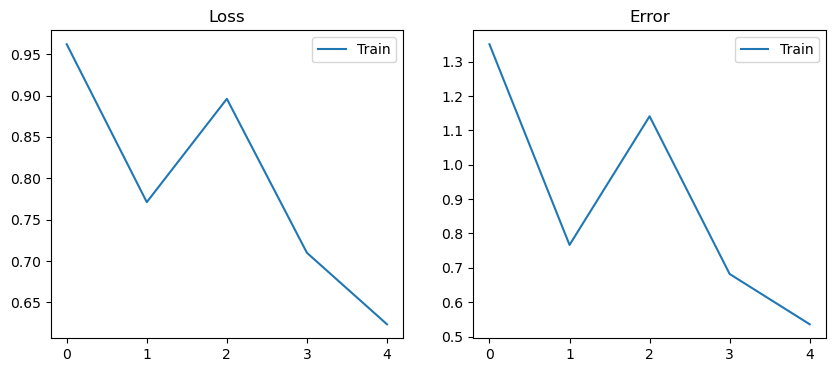

In [ ]:
trainer_lumo.train(data_lumo_lite)

In [ ]:
target_homo = qm9_data["HOMO"][0]
target_lumo = qm9_data["LUMO"][0]
# print([data_homo[50001][0]])
# print(torch.tensor([data_homo[50001][0]]))
# model_homo.predict(torch.tensor([data_homo[50001][0]]))
model_homo.predict(torch.tensor(data_homo[50001][0]).unsqueeze(0))

/var/folders/0z/n9w742pd3bx5nnd8vs21vzf80000gp/T/ipykernel_81445/1050370127.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_homo.predict(torch.tensor(data_homo[50001][0]).unsqueeze(0))


tensor(-6.5593)

# GNN

We got the code to process the SMILE strings into a graph from here: https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/\

In [50]:
gnn_data = []

target_idx = 4
for data in qm9:
    data.y = data.y[:, target_idx]
    gnn_data.append(data)


# Split the dataset into training and testing sets
train_dataset = gnn_data[:50000]
test_dataset = gnn_data[50001:60000]

train_loader = GraphDataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=64, shuffle=False)


In [51]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(qm9.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)  # Outputs one value per graph

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Global pooling
        x = self.lin(x)
        return x

Epoch: 1, Loss: 1.2572
Epoch: 2, Loss: 0.8601
Epoch: 3, Loss: 0.8494
Epoch: 4, Loss: 0.8334
Epoch: 5, Loss: 0.8146
Epoch: 6, Loss: 0.7986
Epoch: 7, Loss: 0.7881
Epoch: 8, Loss: 0.7819
Epoch: 9, Loss: 0.7777


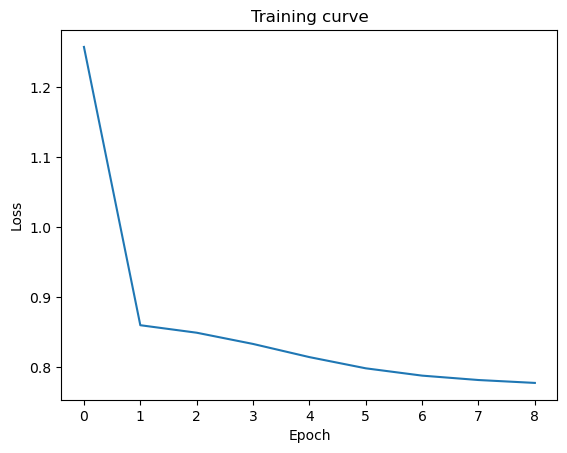

In [54]:
model = GNN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        pred = model(data)
        target = data.y.view(-1, 1).float()
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

losses = []

# Training the model
for epoch in range(1, 10):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch}, Loss: {loss:.4f}')

plt.plot(np.arange(9), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()